# Summary

# Business Understanding

# Data Understanding

### Importing relevant libraries

In [28]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading the dataset


In [3]:
encodings = ['utf-8', 'ISO-8859-1', 'Windows-1252', 'utf-16']
for encoding in encodings:
    try:
        df = pd.read_csv(r'C:\Users\user\Documents\MORINGA\Phase4\Project\Twitter-Sentiment-Analysis\judge-1377884607_tweet_product_company.csv', encoding=encoding)
        print(f"Successfully read the file with encoding: {encoding}")
        break
    except Exception as e:
        print(f"Error with encoding {encoding}: {e}")

Error with encoding utf-8: 'utf-8' codec can't decode byte 0x89 in position 54: invalid start byte
Successfully read the file with encoding: ISO-8859-1


In [4]:
# Printing the first five rows of the data set
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Data Cleaning

In [5]:
# Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


* There are 9093 rows and three columns in our dataset.
* There are missing values in all in a number of rows.

In [6]:
# checking for any pattern in the missing values
# emotion_in_tweet_is directed_at column
df['emotion_in_tweet_is_directed_at'].value_counts()


emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [7]:
# here_an_emotion_directed_at_a_brand_or_product column
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [15]:
# dropping 'i cant tell' and No emotion toward brand or product' category since we will only be using the two sentiments.
df= df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell")]

In [16]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64

In [ ]:
# checking on duplicates

In [23]:

# Function to clean text
def clean_text(text):
    # Ensure text is a string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove hashtags (including the # symbol)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and punctuation (except spaces)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    return text
   
     #Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)

# Function to apply lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

# Apply text cleaning to the "tweet_text" column
df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_text)

# Tokenize the "tweet_text" column
df['tokenized_tweet'] = df['cleaned_tweet_text'].apply(lambda x: word_tokenize(x))

# Apply lemmatization to the tokenized text
df['lemmatized_tweet'] = df['tokenized_tweet'].apply(lemmatize_text)

# Display the DataFrame with cleaned, tokenized, and lemmatized text
print(df[['tweet_text', 'cleaned_tweet_text', 'tokenized_tweet', 'lemmatized_tweet']])

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

                                     cleaned_tweet_text  \
0     wesley83 i have a 3g iphone after 3 hrs tweeti...   
1     jessedee know about fludapp  awesome ipadiphon...   
2     swonderlin can not wait for  2 also they shoul...   
3     sxsw i hope this years festival isnt as crashy...

In [26]:
# Vectorization
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Join the tokenized tweets into a single string with space as a separator
df['lemmatized_tweet'] = df['lemmatized_tweet'].apply(lambda x: ' '.join(x))

# Fit and transform your tokenized text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmatized_tweet'])

# The tfidf_matrix contains the TF-IDF vectors for the tweets

### Exploratory Data Analysis

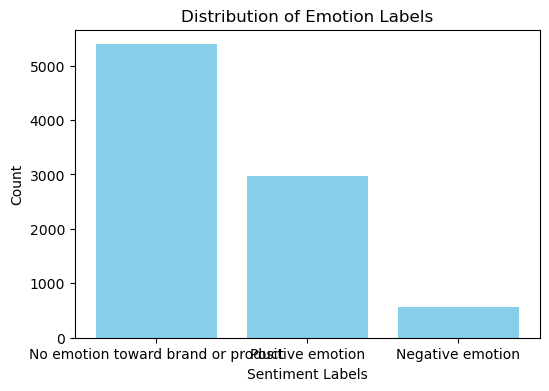

In [29]:
# Assuming you have a DataFrame 'data' with a 'sentiment' column
sentiment_counts = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Create a bar chart to visualize sentiment distribution
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color="skyblue")
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.title('Distribution of Emotion Labels')
plt.show()